# SNA

In [1]:
# automatically reload imports before executing any line in case you changed something
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import read_graph
import viz
import utils

## load data

In [3]:
df = pd.read_csv("../data/Following_Ignoring_Relationships.csv.sample", delimiter=";")
fol_df = df[df["ID_CommunityConnectionType"]==1]
fol_df = fol_df[fol_df["ID_CommunityIdentity"] != fol_df["ID_CommunityIdentityConnectedTo"]]
ign_df = df[df["ID_CommunityConnectionType"]==2]

In [4]:
fol_df[fol_df["ID_CommunityIdentity"] != fol_df["ID_CommunityIdentityConnectedTo"]]

,ID_CommunityIdentity,ID_CommunityIdentityConnectedTo,ID_CommunityConnectionType
0,1778,246490,1
2,9030,23875,1
3,9030,508504,1
5,10569,91850,1
6,10569,547472,1
...,...,...,...
958,27967,196753,1
959,27967,225324,1
960,27967,580733,1
962,29486,137950,1


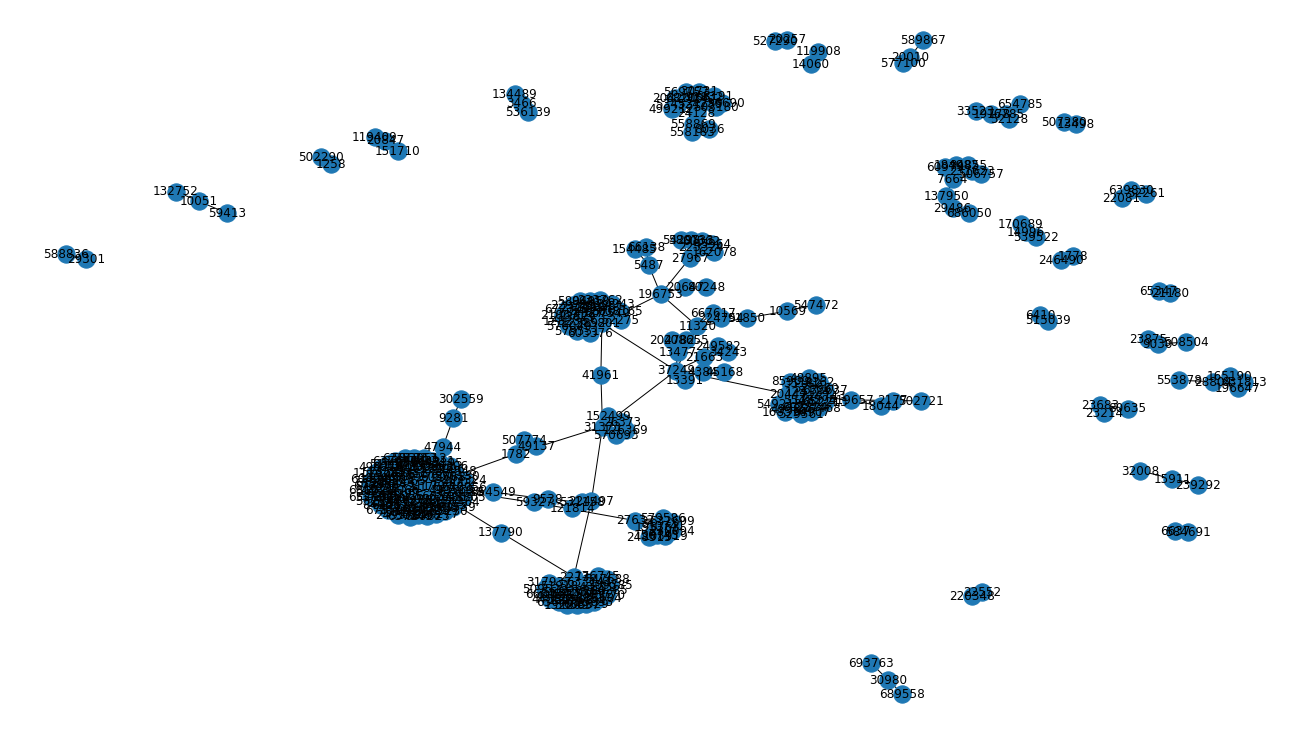

In [5]:
plt.figure(figsize=(18,10))

fol_G = nx.from_pandas_edgelist(fol_df[:1000], source="ID_CommunityIdentity", target="ID_CommunityIdentityConnectedTo")
nx.draw(fol_G, with_labels=True, arrows=True)
plt.show()

## Show shared users between articles

In [4]:
all_postings = utils.read_all_postings()
all_votes = utils.read_all_votes()

In [5]:
postings_1 = all_postings.query("PostingCreatedAt < '2019-05-02'")
votes_1 = all_votes.query("VoteCreatedAt < '2019-05-02'")
postings_1.shape, votes_1.shape

((10446, 14), (63909, 8))

In [6]:
G_art = read_graph.get_articles_shared_users(postings_1)
G_int = read_graph.get_all_users_interactions(postings_1, votes_1)
print("info", nx.info(G_art))
print("info", nx.info(G_int))

info Name: 
Type: Graph
Number of nodes: 95
Number of edges: 1283
Average degree:  27.0105
info Name: 
Type: DiGraph
Number of nodes: 12101
Number of edges: 59756
Average in degree:   4.9381
Average out degree:   4.9381


In [9]:
ccs = [c for c in (G_art.subgraph(c) for c in nx.connected_components(G_art))]
ccs.sort(key=lambda g: len(g.nodes), reverse=True)
len(ccs)

1

In [10]:
wccs = [c for c in (G_int.subgraph(c) for c in nx.weakly_connected_components(G_int))]
wccs.sort(key=lambda g: len(g.nodes), reverse=True)
sccs = [c for c in (G_int.subgraph(c) for c in nx.strongly_connected_components(G_int))]
sccs.sort(key=lambda g: len(g.nodes), reverse=True)
len(wccs), len(sccs)

(104, 9739)

In [11]:
print([len(c.nodes) for c in ccs[:10]])
print([len(c.nodes) for c in wccs[:10]])
print([len(c.nodes) for c in sccs[:10]])

[95]
[6054, 3752, 2072, 7, 5, 4, 4, 4, 3, 3]
[1586, 584, 182, 2, 2, 2, 2, 2, 2, 2]


In [12]:
nx.set_node_attributes(G_art, nx.clustering(G_art), "c_coef")
nx.set_node_attributes(G_art, dict(nx.degree(G_art)), "degree")

nx.set_node_attributes(G_int, nx.clustering(G_int), "c_coef")
nx.set_node_attributes(G_int, utils.get_in_degrees(G_int), "in_degree")

In [13]:
channels = list(postings_1["ArticleChannel"].unique())
nx.set_node_attributes(G_art, {n: channels.index(postings_1.query("ID_Article == '{}'".format(n))["ArticleChannel"].unique()[0]) for n in G_art.nodes()}, "ArticleChannel")

### Plot articles

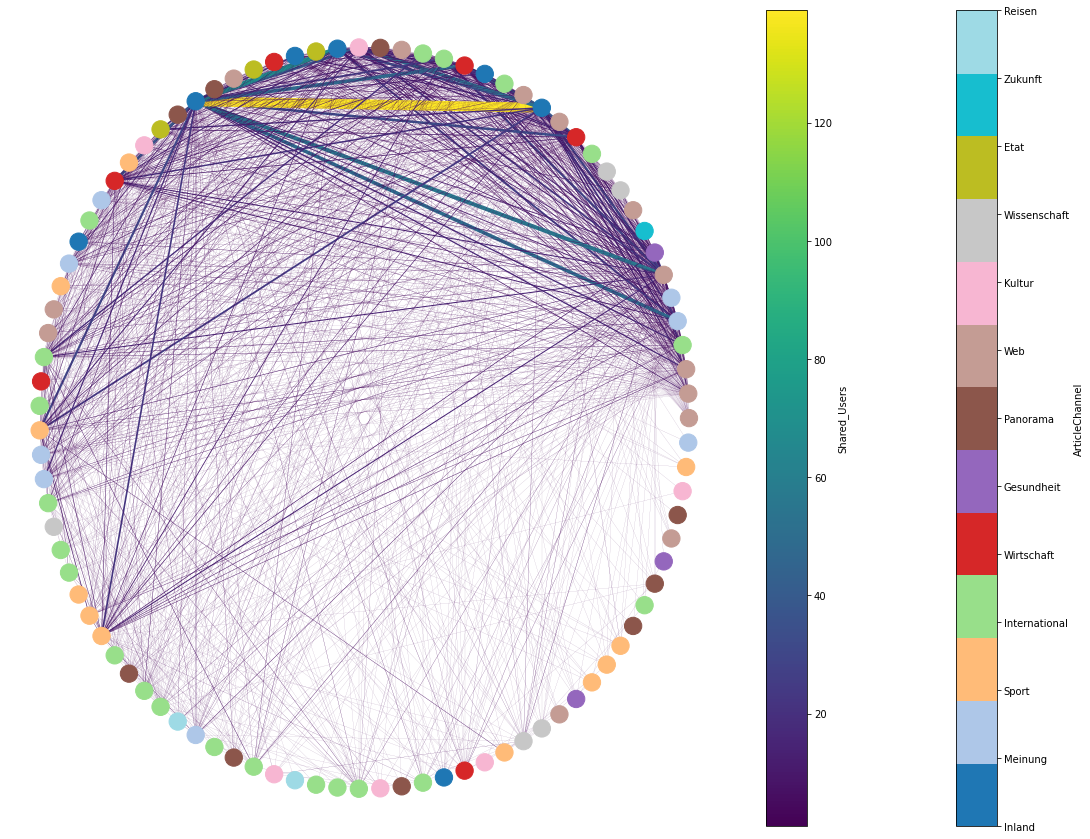

In [14]:
viz.plot_colored_graph(G_art, node_color_attr="ArticleChannel", edge_color_attr="Shared_Users", edge_width_factor=10, pos=nx.circular_layout(G_art), figsize=(20, 15), node_cmap=plt.cm.get_cmap('tab20', len(channels)), node_ticks=channels)

### Plot 3rd largest strongly connected component

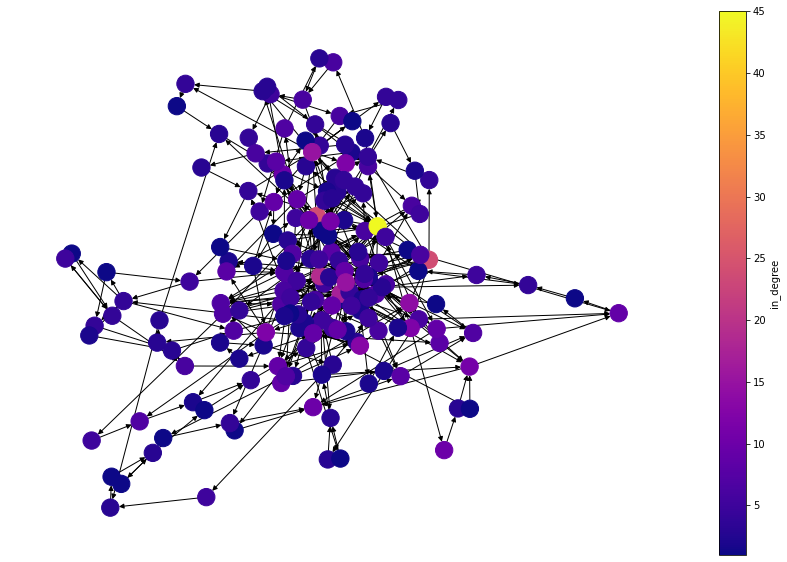

In [15]:
g_int = G_int.subgraph(sccs[2])
viz.plot_colored_graph(g_int, node_color_attr="in_degree", figsize=(15, 10))

### Plot 5 largest distinct cliques 

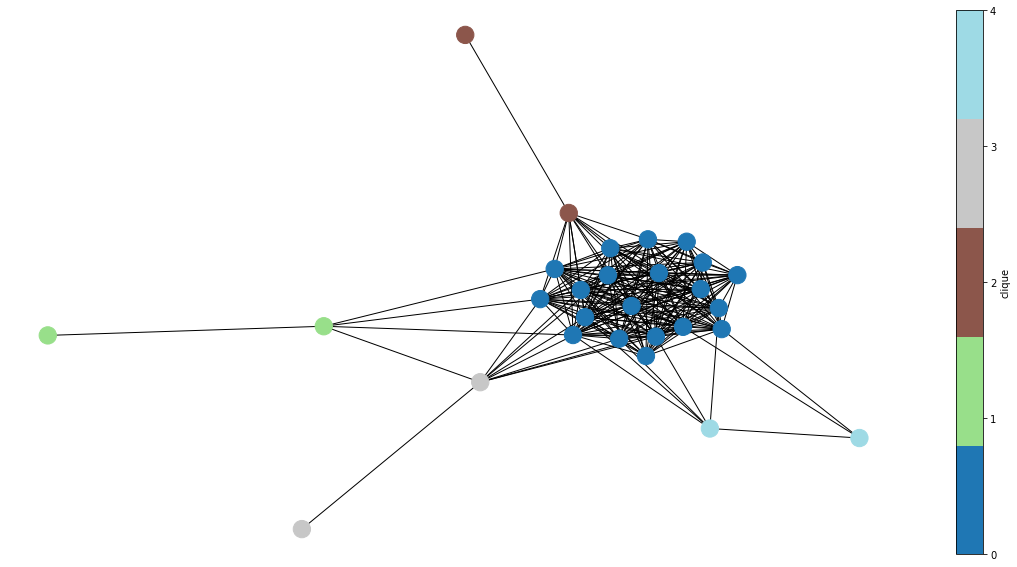

In [16]:
distinct_cliques = utils.get_distinct_cliques(G_art)
for i, c in enumerate(distinct_cliques):
    nx.set_node_attributes(G_art, {n: i for n in c}, "clique")
g_art = G_art.subgraph(sum(distinct_cliques, []))
viz.plot_colored_graph(g_art, "clique", figsize=(20, 10), node_cmap=plt.cm.get_cmap("tab20", len(distinct_cliques)), node_ticks=range(len(distinct_cliques)))

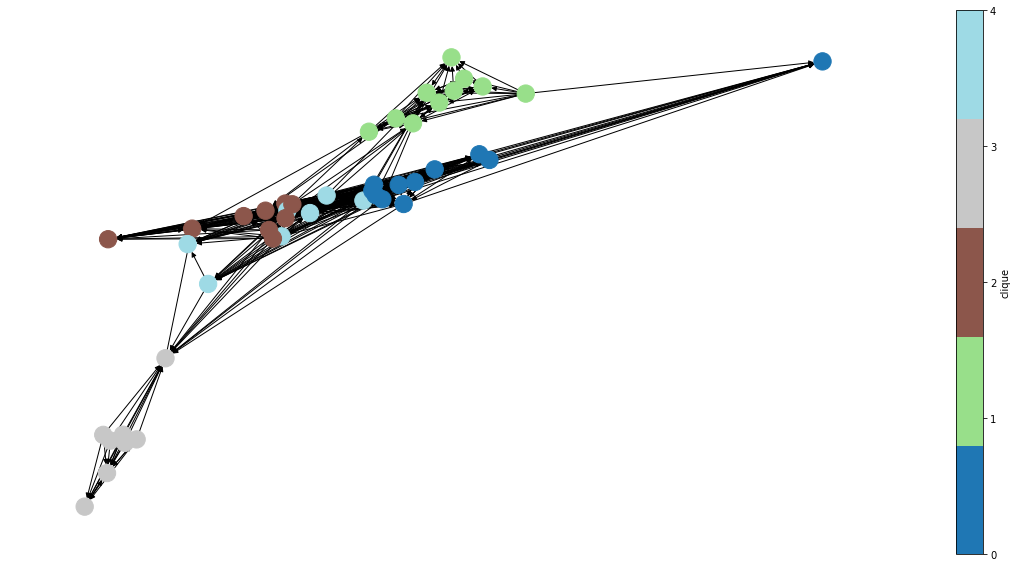

In [17]:
n_cliques = 5
distinct_cliques = utils.get_distinct_cliques(G_int, n=n_cliques)
for i, c in enumerate(distinct_cliques):
    nx.set_node_attributes(G_int, {n: i for n in c}, "clique")
g_int = G_int.subgraph(sum(distinct_cliques, []))
viz.plot_colored_graph(g_int, "clique", figsize=(20, 10), node_cmap=plt.cm.get_cmap("tab20", n_cliques), node_ticks=range(n_cliques))

# Modularity maximization

In [15]:
# get communities in G_int with minimum size 1000
big_communities = utils.get_communities(G_int, min_size=1000)

In [17]:
# show size of found communities
for community in big_communities:
    print(len(community))

3386
2143
2072
1325
1258


In [22]:
# print first 10 nodes in the biggest community
big_communities[0][0:10]

[6066, 6067, 6068, 6069, 6070, 6071, 6072, 6073, 6074, 6075]